# Lab 5 - Topic-based Sentiment Analysis with a Real Dataset


---















In this session, we will build a model for topic-based sentiment analysis: detecting sentiment towards a topic (or target) which is not necessarily present in the text. We use a dataset from a recent public shared task: SemEval 2017 Task 4 subtask B. You can find the whole task description here: https://alt.qcri.org/semeval2017/task4/data/uploads/semeval2017-task4.pdf.

Semeval 2017 task4(subtask B) provides a tweet text dataset with topics.
Given a tweet and a topic, we need to classify the sentiment conveyed towards that topic on a  two-point scale:   POSITIVE vs. NEGATIVE.
Although it is still a binary classification task, this classifier needs to analyze the text and its topic. 

As before, we are going to use Keras Sequential API in this session. The Sequential API allows you to make models layer-by-layer. You could modify the previous models to fit in the new task.

In [1]:
import keras
import numpy as np
from keras.layers import Lambda, GlobalAveragePooling1D, Dense, Embedding
from keras import backend as K
from keras.models import Sequential
import matplotlib.pyplot as plt

from keras.layers import LSTM, RNN, Dropout, Input, LeakyReLU, Bidirectional,Conv1D, GlobalMaxPooling1D
from keras.layers.core import Dense
from keras.models import Model
from keras.utils import plot_model


### Downloading and preprocessing data

Unlike the IMDB dataset we used in previous labs, which is included and preprocessed by Keras, the 
SemEval dataset we will be using here must be downloaded separately. The data is not balanced: the numbers of positive and negative instances are not equal, in either training or test set.


In [2]:
import requests
def downloadfile(url):
  rq = requests.get(url)
  open(url.split('/')[-1], 'wb').write(rq.content)

downloadfile('https://raw.githubusercontent.com/cbaziotis/datastories-semeval2017-task4/master/dataset/Subtask_BD/downloaded/twitter-2016devtest-BD.tsv')
downloadfile('https://raw.githubusercontent.com/cbaziotis/datastories-semeval2017-task4/master/dataset/Subtask_BD/downloaded/twitter-2016dev-BD.tsv')
downloadfile('https://raw.githubusercontent.com/cbaziotis/datastories-semeval2017-task4/master/dataset/Subtask_BD/downloaded/twitter-2016test-BD.tsv')
downloadfile('https://raw.githubusercontent.com/cbaziotis/datastories-semeval2017-task4/master/dataset/Subtask_BD/downloaded/twitter-2016train-BD.tsv')
downloadfile('https://raw.githubusercontent.com/cbaziotis/datastories-semeval2017-task4/master/dataset/Subtask_BD/downloaded/twitter-2015test-BD.tsv')
downloadfile('https://raw.githubusercontent.com/cbaziotis/datastories-semeval2017-task4/master/dataset/Subtask_BD/downloaded/twitter-2015train-BD.tsv')

downloadfile('https://raw.githubusercontent.com/cbaziotis/datastories-semeval2017-task4/master/dataset/Subtask_BD/gold/SemEval2017-task4-test.subtask-BD.english.txt')

with open('twitter-2016dev-BD.tsv', 'r') as f:
  dev_original = [l.strip().split('\t') for l in f.readlines()]
with open('SemEval2017-task4-test.subtask-BD.english.txt', 'r') as f:
  test_original = [l.strip().split('\t') for l in f.readlines()]
train_original = []
with open('twitter-2016train-BD.tsv', 'r') as f:
  train_original = [l.strip().split('\t') for l in f.readlines()]
with open('twitter-2016test-BD.tsv', 'r') as f:
  train_original.extend([l.strip().split('\t') for l in f.readlines()])
with open('twitter-2016devtest-BD.tsv', 'r') as f:
  train_original.extend([l.strip().split('\t') for l in f.readlines()])
with open('twitter-2015test-BD.tsv', 'r') as f:
  train_original.extend([l.strip().split('\t') for l in f.readlines() if l.strip().split('\t')[2] in ['negative','positive']])
with open('twitter-2015train-BD.tsv', 'r') as f:
  train_original.extend([l.strip().split('\t') for l in f.readlines() if l.strip().split('\t')[2] in ['negative','positive']])

print("Training entries: {}".format(len(train_original)))
print("Development entries: {}".format(len(dev_original)))
print("Testing entries: {}".format(len(test_original)))

Training entries: 17639
Development entries: 1325
Testing entries: 6185


We now can start playing around with the data, let’s first see some examples:

In [3]:
print("ID \t TOPIC \t LABLE \t TWEET_TEXT")
print(train_original[0])
print(train_original[1])
print(train_original[2])
print(train_original[3])
print(train_original[4])

ID 	 TOPIC 	 LABLE 	 TWEET_TEXT
['628949369883000832', '@microsoft', 'negative', "dear @Microsoft the newOoffice for Mac is great and all, but no Lync update? C'mon."]
['628976607420645377', '@microsoft', 'negative', "@Microsoft how about you make a system that doesn't eat my friggin discs. This is the 2nd time this has happened and I am so sick of it!"]
['629023169169518592', '@microsoft', 'negative', "I may be ignorant on this issue but... should we celebrate @Microsoft's parental leave changes? Doesn't the gender divide suggest... (1/2)"]
['629179223232479232', '@microsoft', 'negative', 'Thanks to @microsoft, I just may be switching over to @apple.']
['629226490152914944', '@microsoft', 'positive', 'Microsoft, I may not prefer your gaming branch of business. But, you do make a damn fine operating system. #Windows10 @Microsoft']


Build a vocabulary based on the training dataset. 

In [4]:
voc = []
from keras.preprocessing.text import text_to_word_sequence
for example in train_original:
  topic_tokens = text_to_word_sequence(example[1])
  text_tokens = text_to_word_sequence(example[3])
  voc.extend(topic_tokens)
  voc.extend(text_tokens)
voc = set(voc)
print(len(voc))

word_index = dict()
word_index["<PAD>"] = 0
word_index["<START>"] = 1
word_index["<UNK>"] = 2  
word_index["<EOS>"] = 3
for w in voc:
  word_index[w] = len(word_index)
print(word_index)

32571
{'<PAD>': 0, '<START>': 1, '<UNK>': 2, '<EOS>': 3, 'jeffgordonweb': 4, 'rebsallin': 5, 'johnharris1969': 6, 'falsetto': 7, 'adjuvant': 8, 'vast': 9, 'mouth': 10, 'dix': 11, 'hundreds': 12, 'isner': 13, 'proleepriest': 14, '1qzwxtaj3y': 15, 'robertberens': 16, 'foxnewspolitics': 17, 'mornington': 18, 'goodell': 19, 'coaching': 20, 'jarvdawg': 21, 'newcastle': 22, 'nz7m1a9lrp': 23, 'jci': 24, 'mystery': 25, 'sophomore': 26, 'gifs': 27, 'trees': 28, 'gopackgo': 29, 'ed001andonly': 30, 'teamrockbelong': 31, 'mourns': 32, 'zivlwxkpcy': 33, 'byrne': 34, 'bunts': 35, 'matinee': 36, 'm25ifqkatz': 37, "tito's": 38, 'aadmi': 39, 'replacmnt': 40, 'anchor': 41, 'qfs': 42, 'eternally': 43, 'entirely': 44, 'globeandmail': 45, 'boot': 46, 'chukwu': 47, '80smusic': 48, 'xabisomkala': 49, "dunkin'": 50, 'lkt3tn6jq0': 51, 'sabaikhan': 52, 'vehicles': 53, 'vosq1u0pln': 54, 'capitulating': 55, 'grossing': 56, 'bjodczv0mf': 57, 'a2t5xmdhwo': 58, 'jackjackjohnson': 59, 'h5kmqlb01f': 60, 'size': 61, 'b

According to the word_index and the tokenizer function (text_to_word_sequence), we can convert the tweet text and topic words to word tokens and integers separately:


In [5]:
# Please write your code to generate the following data
# x_train_tweet
# x_train_topic
# x_train_tweet_int
# x_train_topic_int

# x_dev_tweet
# x_dev_topic
# x_dev_tweet_int
# x_dev_topic_int

# x_test_tweet
# x_test_topic
# x_test_tweet_int
# x_test_topic_int



##### your code goes here:
x_train_tweet= [text_to_word_sequence(i[3]) for i in train_original]
x_train_topic= [text_to_word_sequence(i[1]) for i in train_original]
x_train_tweet_int = [[word_index[token] if token in word_index.keys() else 2 for token in tweet] for tweet in x_train_tweet]
x_train_topic_int = [[word_index[token] if token in word_index.keys() else 2 for token in topic] for topic in x_train_topic]

x_dev_tweet = [text_to_word_sequence(i[3]) for i in dev_original]
x_dev_topic = [text_to_word_sequence(i[1]) for i in dev_original]
x_dev_tweet_int = [[word_index[token] if token in word_index.keys() else 2 for token in tweet] for tweet in x_dev_tweet]
x_dev_topic_int = [[word_index[token] if token in word_index.keys() else 2 for token in topic] for topic in x_dev_topic]

x_test_tweet = [text_to_word_sequence(i[3]) for i in test_original]
x_test_topic = [text_to_word_sequence(i[1]) for i in test_original]
x_test_tweet_int = [[word_index[token] if token in word_index.keys() else 2 for token in tweet] for tweet in x_test_tweet]
x_test_topic_int = [[word_index[token] if token in word_index.keys() else 2 for token in topic] for topic in x_test_topic]
# If use the previous word_index, you can get a print result like:
assert len(x_train_topic) == len(train_original)
assert len(x_train_topic) == len(x_train_topic_int)
assert len(x_test_topic) == len(test_original)
assert len(x_test_topic) == len(x_test_topic_int)
print("x_dev_tweet[0]:")
print(x_dev_tweet[0])
print("x_dev_topic[0]:")
print(x_dev_topic[0])
print("x_dev_tweet_int[0]:")
print(x_dev_tweet_int[0])
print("x_dev_topic_int[0]:")
print(x_dev_topic_int[0])

x_dev_tweet[0]:
['jay', 'z', 'joins', 'instagram', 'with', 'nostalgic', 'tribute', 'to', 'michael', 'jackson', 'jay', 'z', 'apparently', 'joined', 'instagram', 'on', 'saturday', 'and', 'http', 't', 'co', 'qj9i4ecvxy']
x_dev_topic[0]:
['michael', 'jackson']
x_dev_tweet_int[0]:
[7269, 7022, 1054, 25880, 24821, 28295, 25462, 16889, 15313, 7882, 7269, 7022, 25999, 14715, 25880, 25333, 16110, 4229, 21320, 21173, 23229, 2]
x_dev_topic_int[0]:
[15313, 7882]


We use 1 to represent "positive" and 0 for "negative" and generate the "y" data similar to previous labs.

In [6]:
def label2int(dataset):
  y = []
  for example in dataset:
    if example[2].lower() == "negative":
      y.append(0)
    else:
      y.append(1)
  return y
  
y_train = label2int(train_original)
y_dev = label2int(dev_original)
y_test = label2int(test_original)
y_train = np.array(y_train)
y_dev = np.array(y_dev)
y_test = np.array(y_test)

print(y_train[0])
print(y_train[1])
print(y_train[2])
print(y_train[3])
print(y_train[4])

0
0
0
0
1


Now we have almost done the data preprocessing. Unlike the previous lab, there are two x (tweet and topic) to input the model in here. The easiest way is to combine the tweet and topic into one sentence and then input it into the model. Thus we can use the previous model directly.

Note: the IMDB does not contain a development set, so we split part of the training data as a development set. In SEMEVAL2017, there is a development set, so we do not need to split the training data and do not forget to preprocess the development set data.

In [7]:
# Please write your code to combine the x_*_tweet and x_*_topic into the following varibles
x_train = [topic + tokens for topic, tokens in zip(x_train_topic, [['<START>']+tokens for tokens in x_train_tweet])]
x_train_int = [[word_index[token] if token in word_index.keys() else 2 for token in item] for item in x_train]

x_dev = [topic + tokens for topic, tokens in zip(x_dev_topic, [['<START>']+tokens for tokens in x_dev_tweet])]
x_dev_int = [[word_index[token] if token in word_index.keys() else 2 for token in item] for item in x_dev]

x_test = [topic + tokens for topic, tokens in zip(x_test_topic, [['<START>']+tokens for tokens in x_test_tweet])]
x_test_int = [[word_index[token] if token in word_index.keys() else 2 for token in item] for item in x_test]

# Tips: 
# 1) We can use the special token <START> to concatenate the tweets and topics.
# 2) After combine them, do not foget to pad the sequences.


##### your code goes here:
x_train_pad = np.array(keras.preprocessing.sequence.pad_sequences(x_train_int,padding='post',maxlen=128,value = 0.0))
x_dev_pad = np.array(keras.preprocessing.sequence.pad_sequences(x_dev_int,value=0.0,padding='post',maxlen=128))

x_test_pad = np.array(keras.preprocessing.sequence.pad_sequences(x_test_int,value=0.0,padding='post',maxlen=128))

# Don't forget the to use np.array function to wrap the ouput of pad_sequences function, such as: x_train_pad = np.array(x_train_pad)
# Only pad the *_int varibles
print("Before paded:")
print(x_train[0])
print(x_train_int[0])
print("After paded:")
print(x_train_pad[0])

Before paded:
['microsoft', '<START>', 'dear', 'microsoft', 'the', 'newooffice', 'for', 'mac', 'is', 'great', 'and', 'all', 'but', 'no', 'lync', 'update', "c'mon"]
[31463, 1, 3310, 31463, 29114, 6170, 20972, 9602, 30518, 5879, 4229, 18197, 5883, 13993, 8537, 19463, 16854]
After paded:
[31463     1  3310 31463 29114  6170 20972  9602 30518  5879  4229 18197
  5883 13993  8537 19463 16854     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0   

#Model 1: Previous models without pre-trained word embeddings

## Model 1-1: Neural bag of words without pre-trained word embeddings

Now we use the model2 in lab4 to deal with the SEMEVAL2017 task4 subtask B. We have preprocess the data to fit in this model in previous steps.

In [8]:
class GlobalAveragePooling1DMasked(GlobalAveragePooling1D):
    def call(self, x, mask=None):
        if mask != None:
            return K.sum(x, axis=1) / K.sum(mask, axis=1)
        else:
            return super().call(x)


In [9]:
# your code goes here
MAX_SEQUENCE_LENGTH = 128
VOCAB_SIZE = 32575
input_review = Input ( (MAX_SEQUENCE_LENGTH, ), dtype='int32')
EMBED_SIZE = 100
review_embed = Embedding(VOCAB_SIZE, EMBED_SIZE, name='target_embed_layer', input_length = MAX_SEQUENCE_LENGTH)(input_review)
layer2 = GlobalAveragePooling1DMasked() (review_embed)

layer3 = Dense(16, activation='sigmoid') (layer2)

label = Dense(1, activation = 'sigmoid') (layer3)

model = Model (inputs=[input_review], outputs=[label])
model.summary()
model.compile(optimizer = 'adam', loss = 'binary_crossentropy',metrics=['accuracy'])
history = model.fit(x_train_pad,
                    y_train,
                    epochs=30,
                    batch_size=512,
                    validation_data=(x_dev_pad, y_dev))

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128)]             0         
_________________________________________________________________
target_embed_layer (Embeddin (None, 128, 100)          3257500   
_________________________________________________________________
global_average_pooling1d_mas (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 16)                1616      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 3,259,133
Trainable params: 3,259,133
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
35/35 [==============================] - 2s 37ms/step - loss: 0.5517 - accuracy: 0.7895 - val_loss: 0.5680

In [10]:
model.evaluate(x_test_pad,y_test)

194/194 [==============================] - 0s 2ms/step - loss: 0.5256 - accuracy: 0.7450


[0.5256087779998779, 0.7450283169746399]

The accuracy of the lab4 model2 in this task is around 78%. 

##  Model 1-2: CNN or LSTM without pre-trained word embeddings

Please try one more model (CNN or LSTM) without pre-trained word embeddings in here:

In [12]:
# Try CNN or LSTM without pre-trained word embeddings in here:
from keras.layers import Conv1D
input_tweet = Input((MAX_SEQUENCE_LENGTH), dtype = 'int32')
embed = Embedding(VOCAB_SIZE, 100, name ='embed_layer',
                            embeddings_initializer = 'glorot_uniform', 
                             input_length=MAX_SEQUENCE_LENGTH)(input_tweet)
CNN_layer1 = Conv1D(filters = 100, kernel_size = 6)(embed)
layer1 = GlobalAveragePooling1D()(CNN_layer1)
layer2 = Dense(16, activation='sigmoid') (layer1)

label = Dense(1, activation = 'sigmoid')(layer2)

model2 = Model(inputs=[input_tweet], outputs=[label])  
model2.compile(optimizer='adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
model2.summary()
model2.compile(optimizer = 'adam', loss = 'binary_crossentropy',metrics=['accuracy'])
history = model2.fit(x_train_pad,
                    y_train,
                    epochs=30,
                    batch_size=512,
                    validation_data=(x_dev_pad, y_dev))

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 128)]             0         
_________________________________________________________________
embed_layer (Embedding)      (None, 128, 100)          3257500   
_________________________________________________________________
conv1d (Conv1D)              (None, 123, 100)          60100     
_________________________________________________________________
global_average_pooling1d (Gl (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                1616      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 3,319,233
Trainable params: 3,319,233
Non-trainable params: 0
_________________________________________________

In [13]:
model2.evaluate(x_test_pad,y_test)

194/194 [==============================] - 1s 3ms/step - loss: 1.0615 - accuracy: 0.7258


[1.0615345239639282, 0.7257881760597229]

# Model 2: Using pre-trained word embeddings

### Preparing pre-trained word embeddings (GLOVE)

The Embedding layer can be used to load a pre-trained word embedding model. We are going to use GloVe embeddings, which you can read about it here (https://nlp.stanford.edu/projects/glove/). GloVe stands for "Global Vectors for Word Representation". It's a somewhat popular embedding technique based on factorizing a matrix of word co-occurence statistics. You can download GloVe and we can seed the Keras Embedding layer with weights from the pre-trained embedding for the words in your dataset.
First, we need to read GloVe and map words to GloVe:


In [9]:
def readGloveFile(gloveFile):
    with open(gloveFile, 'r') as f:
        wordToGlove = {}  
        wordToIndex = {}  
        indexToWord = {}  

        for line in f:
            record = line.strip().split()
            token = record[0] 
            wordToGlove[token] = np.array(record[1:], dtype=np.float64) 
            
        tokens = sorted(wordToGlove.keys())
        for idx, tok in enumerate(tokens):
            kerasIdx = idx + 1  
            wordToIndex[tok] = kerasIdx 
            indexToWord[kerasIdx] = tok 

    return wordToIndex, indexToWord, wordToGlove

Now, we create our pre-trained Embedding layer:

In [15]:
from keras.initializers import Constant

def createPretrainedEmbeddingLayer(wordToGlove, wordToIndex, isTrainable):
    vocabLen = len(wordToIndex) + 1  
    embDim = next(iter(wordToGlove.values())).shape[0]  
   
    embeddingMatrix = np.zeros((vocabLen, embDim))  
    for word, index in wordToIndex.items():
        embeddingMatrix[index, :] = wordToGlove[word] 

    embeddingLayer = Embedding(vocabLen, embDim, embeddings_initializer=Constant(embeddingMatrix), trainable=isTrainable, name='GloVe_Embeddings')
    return embeddingLayer

In [16]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip '/content/glove.6B.zip'

--2021-03-04 07:48:19--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2021-03-04 07:48:19--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2021-03-04 07:48:19--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

We freeze the weights. To create the model: 

In [17]:
# wordToIndex,indexToWord,wordToGlove=readGloveFile('/content/glove.6B.50d.txt')
# wordToIndex,indexToWord,wordToGlove=readGloveFile('/content/glove.6B.100d.txt')
wordToIndex,indexToWord,wordToGlove=readGloveFile('/content/glove.6B.300d.txt')

# vocabLen = len(wordToIndex) + 1 

EMBED_SIZE = next(iter(wordToGlove.values())).shape[0]
print('Size of Embedding: ',EMBED_SIZE)

embeddingLayer=createPretrainedEmbeddingLayer(wordToGlove,wordToIndex,isTrainable=False)
embeddingLayer2=createPretrainedEmbeddingLayer(wordToGlove,wordToIndex,isTrainable=True)

Size of Embedding:  300


### Convert the data to GLOVE word index

The index in our vocabulary is different from that in GLOVE. For example, the word "you" corresponds to 394475 in GLOVE, while it corresponds to another index in our vocabulary. Thus we can not directly use the index data in the last section. We convert them from text tokens to GLOVE word index.

In [15]:
print(wordToIndex["you"])
print(indexToWord[394475])
print(word_index["you"])

394475
you
17469


In [18]:
# Please write your code to generate the following data
x_train_tweet_glove = [[wordToIndex[token] if token in wordToIndex.keys() else 2 for token in tweet] for tweet in x_train_tweet]
x_train_topic_glove = [[wordToIndex[token] if token in wordToIndex.keys() else 2 for token in tweet] for tweet in x_train_topic]

x_dev_tweet_glove = [[wordToIndex[token] if token in wordToIndex.keys() else 2 for token in tweet] for tweet in x_dev_tweet]
x_dev_topic_glove = [[wordToIndex[token] if token in wordToIndex.keys() else 2 for token in tweet] for tweet in x_dev_topic]

x_test_tweet_glove = [[wordToIndex[token] if token in wordToIndex.keys() else 2 for token in tweet] for tweet in x_test_tweet]
x_test_topic_glove = [[wordToIndex[token] if token in wordToIndex.keys() else 2 for token in tweet] for tweet in x_test_topic]



##### your code goes here:



# You should get a print result like:
assert len(x_train_tweet_glove) == len(train_original)
assert len(x_train_topic_glove) == len(x_train_topic_int)
assert len(x_test_tweet_glove) == len(test_original)
assert len(x_test_topic_glove) == len(x_test_topic_int)
print("x_dev_tweet_glove[0]:")
print(x_dev_tweet_glove[0])
print("x_dev_topic_glove[0]:")
print(x_dev_topic_glove[0])

x_dev_tweet_glove[0]:
[196237, 395262, 198486, 190716, 388711, 264529, 365027, 360915, 242891, 194733, 196237, 395262, 57698, 198478, 190716, 269798, 319134, 54718, 182915, 350784, 103530, 2]
x_dev_topic_glove[0]:
[242891, 194733]


As before, we concatenate the tweets and topics for fitting in the previous model. Let us do it again for GLOVE version variables.

In [19]:
# Please write your code to combine the x_*_tweet_glove and x_*_topic_glove into the following varibles
x_train_glove = [topic + tokens for topic, tokens in zip(x_train_topic_glove, [[1]+tokens for tokens in x_train_tweet_glove])]
x_dev_glove = [topic + tokens for topic, tokens in zip(x_dev_topic_glove, [[1]+tokens for tokens in x_dev_tweet_glove])]
x_test_glove = [topic + tokens for topic, tokens in zip(x_test_topic_glove, [[1]+tokens for tokens in x_test_tweet_glove])]

# Tips: 
# 1) There is no <START> token in GLOVE. Here we can use integer 1 to concatenate.
# 2) After combine them, do not foget to pad the sequences.


##### your code goes here:
x_train_pad_glove = keras.preprocessing.sequence.pad_sequences(x_train_glove,
                                                        value=word_index["<PAD>"],
                                                        padding='post',
                                                        maxlen=128)

x_dev_pad_glove = keras.preprocessing.sequence.pad_sequences(x_dev_glove,
                                                        value=word_index["<PAD>"],
                                                        padding='post',
                                                        maxlen=128)

x_test_pad_glove = keras.preprocessing.sequence.pad_sequences(x_test_glove,
                                                        value=word_index["<PAD>"],
                                                        padding='post',
                                                        maxlen=128)

x_train_pad_glove = np.array(x_train_pad_glove)
x_dev_pad_glove = np.array(x_dev_pad_glove)
x_test_pad_glove = np.array(x_test_pad_glove)

# Don't forget the to use np.array function to wrap the ouput of pad_sequences function, such as: x_train_pad = np.array(x_train_pad)
# Only pad the *_int varibles
print("Before paded:")
print(x_train_glove[0])
print("After paded:")
print(x_train_pad_glove[0])

Before paded:
[243317, 1, 118309, 243317, 357266, 2, 151349, 229153, 192973, 166369, 54718, 51582, 87775, 262350, 228306, 373375, 88558]
After paded:
[243317      1 118309 243317 357266      2 151349 229153 192973 166369
  54718  51582  87775 262350 228306 373375  88558      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      

## Model 2-1: Neural bag of words using pre-trained word embeddings

We use model3-1 in lab4 to deal with this task.

In [28]:
# your code goes here
# Tips: Do not misuse the training data
tweets_input = Input((MAX_SEQUENCE_LENGTH), dtype = 'int32')

embedding_layer = embeddingLayer(tweets_input)

layer1 = GlobalAveragePooling1DMasked()(embedding_layer)
layer2 = Dense(16, activation = 'sigmoid')(layer1)

label = Dense(1, activation='sigmoid')(layer2)

model3 = Model(inputs = [tweets_input], outputs = [label])
model3.compile(optimizer = 'adam', loss='binary_crossentropy', metrics = ['accuracy'])
model3.summary()
history_2_1 = model3.fit(x_train_pad_glove,
                    y_train,
                    epochs=200,
                    batch_size=512,
                    validation_data=(x_dev_pad_glove, y_dev),
                    verbose=1)


Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 128)]             0         
_________________________________________________________________
GloVe_Embeddings (Embedding) (None, 128, 300)          120000300 
_________________________________________________________________
global_average_pooling1d_mas (None, 300)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 16)                4816      
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 17        
Total params: 120,005,133
Trainable params: 4,833
Non-trainable params: 120,000,300
_________________________________________________________________
Epoch 1/200
35/35 [==============================] - 2s 28ms/step - loss: 0.7415 - accuracy: 0.2969 - val_l

In [29]:
results2 = model3.evaluate(x_test_pad_glove, y_test)

194/194 [==============================] - 1s 3ms/step - loss: 0.4560 - accuracy: 0.7888


##  Model 2-2: CNN or LSTM with pre-trained word embeddings

Please try one more model (CNN or LSTM) with pre-trained word embeddings in here:

In [57]:
# your code goes here
tweets_input = Input((MAX_SEQUENCE_LENGTH), dtype = 'int32')

embedding_layer = embeddingLayer(tweets_input)

CNN_layer = Conv1D(filters = 100, kernel_size = 6)(embedding_layer)
layer1 = GlobalAveragePooling1D()(CNN_layer)

label = Dense(1, activation = 'sigmoid')(layer1)

model4 = Model(inputs=[tweets_input], outputs=[label])  
model4.compile(optimizer='adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

model4.summary()


Model: "model_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_21 (InputLayer)        [(None, 128)]             0         
_________________________________________________________________
GloVe_Embeddings (Embedding) (None, 128, 300)          120000300 
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 123, 100)          180100    
_________________________________________________________________
global_average_pooling1d_11  (None, 100)               0         
_________________________________________________________________
dense_28 (Dense)             (None, 1)                 101       
Total params: 120,180,501
Trainable params: 180,201
Non-trainable params: 120,000,300
_________________________________________________________________


In [58]:
history_4 = model4.fit(x_train_pad_glove,
                    y_train,
                    epochs=200,
                    batch_size=512,
                    validation_data=(x_dev_pad_glove, y_dev),
                    verbose=1)

Epoch 1/200
35/35 [==============================] - 2s 36ms/step - loss: 0.5371 - accuracy: 0.7603 - val_loss: 0.4990 - val_accuracy: 0.7449
Epoch 2/200
35/35 [==============================] - 1s 32ms/step - loss: 0.4075 - accuracy: 0.8227 - val_loss: 0.4333 - val_accuracy: 0.7887
Epoch 3/200
35/35 [==============================] - 1s 32ms/step - loss: 0.3624 - accuracy: 0.8481 - val_loss: 0.4131 - val_accuracy: 0.8015
Epoch 4/200
35/35 [==============================] - 1s 32ms/step - loss: 0.3434 - accuracy: 0.8567 - val_loss: 0.4132 - val_accuracy: 0.8060
Epoch 5/200
35/35 [==============================] - 1s 32ms/step - loss: 0.3383 - accuracy: 0.8565 - val_loss: 0.4029 - val_accuracy: 0.8136
Epoch 6/200
35/35 [==============================] - 1s 32ms/step - loss: 0.3162 - accuracy: 0.8731 - val_loss: 0.4025 - val_accuracy: 0.8158
Epoch 7/200
35/35 [==============================] - 1s 32ms/step - loss: 0.3247 - accuracy: 0.8627 - val_loss: 0.4049 - val_accuracy: 0.8158
Epoch 

In [59]:
results_4 = model4.evaluate(x_test_pad_glove, y_test)
print(results_4)

194/194 [==============================] - 1s 3ms/step - loss: 0.4661 - accuracy: 0.7900
[0.4660947024822235, 0.7899757623672485]


#  Model 3: Model with multiple-input

Model 1 and 2 are copied from lab4. We build new models in this section. 

In models 1 and 2, we combine the topics and tweets to input into the models. In model 3, we separately input these two data into the model and use different layers to analyze topics and tweets. 

In [20]:
# First of all, pad the tweet and topic separately
x_train_tweet_pad_glove = keras.preprocessing.sequence.pad_sequences(x_train_tweet_glove,
                                                        value=0,
                                                        padding='post',
                                                        maxlen=128)

x_dev_tweet_pad_glove = keras.preprocessing.sequence.pad_sequences(x_dev_tweet_glove,
                                                       value=0,
                                                       padding='post',
                                                       maxlen=128)

x_test_tweet_pad_glove = keras.preprocessing.sequence.pad_sequences(x_test_tweet_glove,
                                                       value=0,
                                                       padding='post',
                                                       maxlen=128)

x_train_topic_pad_glove = keras.preprocessing.sequence.pad_sequences(x_train_topic_glove,
                                                        value=0,
                                                        padding='post',
                                                        maxlen=16)

x_dev_topic_pad_glove = keras.preprocessing.sequence.pad_sequences(x_dev_topic_glove,
                                                       value=0,
                                                       padding='post',
                                                       maxlen=16)

x_test_topic_pad_glove = keras.preprocessing.sequence.pad_sequences(x_test_topic_glove,
                                                       value=0,
                                                       padding='post',
                                                       maxlen=16)

## Model 3-1 Neural bag of words model with multiple-input

Model 3-1 needs you to modify the model 2-1 to be compatible with multiple-input.
You could find some tutorial examples from (https://www.pyimagesearch.com/2019/02/04/keras-multiple-inputs-and-mixed-data/).

Please print the model summary and visualize it using vis_utils.

In [37]:
# your code goes here
from keras.layers import Concatenate

input1 = Input((16), dtype = 'int32') ## topic input
input2 = Input((MAX_SEQUENCE_LENGTH), dtype = 'int32') ## tweet input

review_embedding = embeddingLayer(input1)
review_embedding2 = embeddingLayer(input2)

global_avg1= GlobalAveragePooling1DMasked()(review_embedding)
global_avg2 = GlobalAveragePooling1DMasked()(review_embedding2)

layer1 = Dense(16, activation = 'sigmoid')(global_avg1)
layer2 = Dense(16, activation='sigmoid')(global_avg2)

layer3 = Concatenate()([layer1, layer2])

label = Dense(1, activation='sigmoid')(layer3)

model_5 = Model(inputs = [input1, input2], outputs = [label])
model_5.compile(optimizer = 'adam', loss='binary_crossentropy', metrics = ['accuracy'])
model_5.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 16)]         0                                            
__________________________________________________________________________________________________
input_11 (InputLayer)           [(None, 128)]        0                                            
__________________________________________________________________________________________________
GloVe_Embeddings (Embedding)    multiple             120000300   input_10[0][0]                   
                                                                 input_11[0][0]                   
__________________________________________________________________________________________________
global_average_pooling1d_masked (None, 300)          0           GloVe_Embeddings[6][0]     

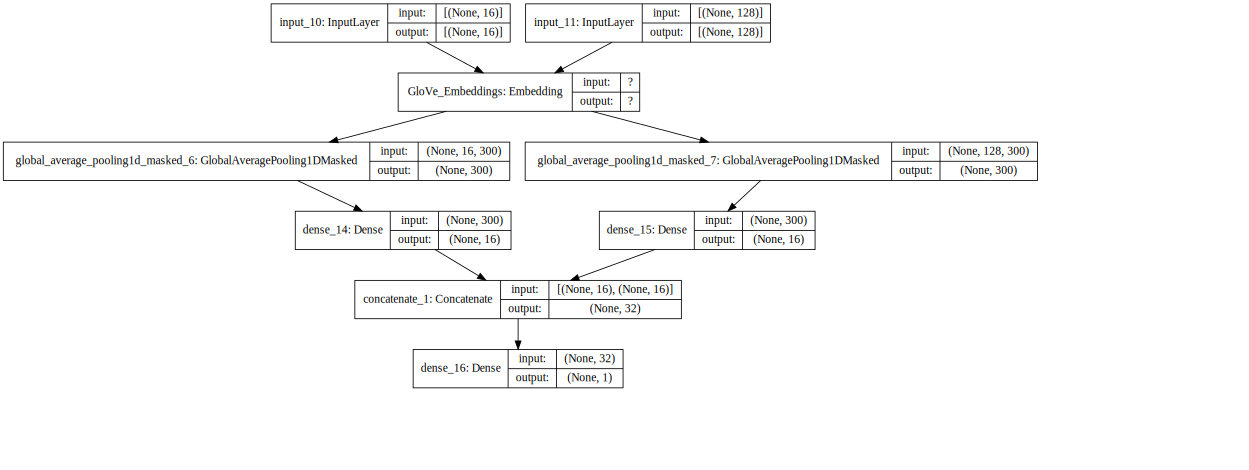

In [39]:
from IPython.display import SVG
from keras.utils import vis_utils
SVG(vis_utils.model_to_dot(model_5, show_shapes=True, show_layer_names=True, dpi=60).create(prog='dot', format='svg'))  

Train and evaluate your model:

In [40]:
# your code goes here
history_5 = model_5.fit([x_train_topic_pad_glove, x_train_tweet_pad_glove],
                    y_train,
                    epochs=200,
                    batch_size=512,
                    validation_data=([x_dev_topic_pad_glove, x_dev_tweet_pad_glove], y_dev),
                    verbose=1)


Epoch 1/200
35/35 [==============================] - 2s 30ms/step - loss: 0.5779 - accuracy: 0.7939 - val_loss: 0.5668 - val_accuracy: 0.7442
Epoch 2/200
35/35 [==============================] - 1s 24ms/step - loss: 0.5127 - accuracy: 0.7887 - val_loss: 0.5663 - val_accuracy: 0.7442
Epoch 3/200
35/35 [==============================] - 1s 24ms/step - loss: 0.5018 - accuracy: 0.7893 - val_loss: 0.5608 - val_accuracy: 0.7442
Epoch 4/200
35/35 [==============================] - 1s 24ms/step - loss: 0.4984 - accuracy: 0.7869 - val_loss: 0.5545 - val_accuracy: 0.7442
Epoch 5/200
35/35 [==============================] - 1s 24ms/step - loss: 0.4872 - accuracy: 0.7896 - val_loss: 0.5482 - val_accuracy: 0.7442
Epoch 6/200
35/35 [==============================] - 1s 24ms/step - loss: 0.4798 - accuracy: 0.7901 - val_loss: 0.5418 - val_accuracy: 0.7442
Epoch 7/200
35/35 [==============================] - 1s 25ms/step - loss: 0.4739 - accuracy: 0.7907 - val_loss: 0.5353 - val_accuracy: 0.7442
Epoch 

In [43]:
results_5 = model_5.evaluate([x_test_topic_pad_glove, x_test_tweet_pad_glove], y_test)
print(results_5)

194/194 [==============================] - 1s 3ms/step - loss: 0.5301 - accuracy: 0.7639
[0.5300872325897217, 0.7639450430870056]


## Model 3-2 CNN or LSTM model with multiple-input

Modify the previous CNN or LSTM model to be compatible with multiple-input, similar to model 3-1. 

In [44]:
# your code goes here
input1 = Input((16), dtype = 'int32') ## topic input
input2 = Input((MAX_SEQUENCE_LENGTH), dtype = 'int32') ## tweet input

embedding_layer = embeddingLayer(input1)
embedding_layer2 = embeddingLayer(input2)

CNN_layer = Conv1D(filters = 100, kernel_size = 6)(embedding_layer)
CNN_layer2 = Conv1D(filters = 100, kernel_size = 6)(embedding_layer2)

layer1 = GlobalAveragePooling1D()(CNN_layer)
layer2 = GlobalAveragePooling1D()(CNN_layer2)

layer3 = Dense(16, activation = 'sigmoid')(layer1)
layer4 = Dense(16, activation='sigmoid')(layer2)

layer5 = Concatenate()([layer3, layer4])

label = Dense(1, activation='sigmoid')(layer5)

model_6 = Model(inputs = [input1, input2], outputs = [label])
model_6.compile(optimizer = 'adam', loss='binary_crossentropy', metrics = ['accuracy'])
model_6.summary()


Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           [(None, 16)]         0                                            
__________________________________________________________________________________________________
input_13 (InputLayer)           [(None, 128)]        0                                            
__________________________________________________________________________________________________
GloVe_Embeddings (Embedding)    multiple             120000300   input_12[0][0]                   
                                                                 input_13[0][0]                   
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 11, 100)      180100      GloVe_Embeddings[8][0]     

In [45]:
history_6 = model_6.fit([x_train_topic_pad_glove, x_train_tweet_pad_glove],
                    y_train,
                    epochs=200,
                    batch_size=512,
                    validation_data=([x_dev_topic_pad_glove, x_dev_tweet_pad_glove], y_dev),
                    verbose=1)

Epoch 1/200
35/35 [==============================] - 2s 41ms/step - loss: 0.5607 - accuracy: 0.7900 - val_loss: 0.5429 - val_accuracy: 0.7442
Epoch 2/200
35/35 [==============================] - 1s 35ms/step - loss: 0.4352 - accuracy: 0.8143 - val_loss: 0.4741 - val_accuracy: 0.7374
Epoch 3/200
35/35 [==============================] - 1s 35ms/step - loss: 0.3823 - accuracy: 0.8429 - val_loss: 0.4327 - val_accuracy: 0.7653
Epoch 4/200
35/35 [==============================] - 1s 35ms/step - loss: 0.3442 - accuracy: 0.8578 - val_loss: 0.4109 - val_accuracy: 0.7962
Epoch 5/200
35/35 [==============================] - 1s 35ms/step - loss: 0.3221 - accuracy: 0.8669 - val_loss: 0.3981 - val_accuracy: 0.8189
Epoch 6/200
35/35 [==============================] - 1s 35ms/step - loss: 0.3012 - accuracy: 0.8772 - val_loss: 0.3904 - val_accuracy: 0.8287
Epoch 7/200
35/35 [==============================] - 1s 35ms/step - loss: 0.2979 - accuracy: 0.8768 - val_loss: 0.3898 - val_accuracy: 0.8204
Epoch 

In [46]:
results_6 = model_6.evaluate([x_test_topic_pad_glove, x_test_tweet_pad_glove], y_test)
print(results_6)

194/194 [==============================] - 1s 3ms/step - loss: 0.7018 - accuracy: 0.7378
[0.7018463015556335, 0.7377526164054871]


## Question 5 to improve accuracy more than 81%:

### First Try

In [21]:
from keras.layers import Concatenate
input1 = Input((16), dtype = 'int32') ## topic input
input2 = Input((128), dtype = 'int32') ## tweet input

embedding_layer = embeddingLayer(input1)
embedding_layer2 = embeddingLayer(input2)

CNN_layer = Conv1D(filters = 128, kernel_size = 4, activation="relu", strides=3)(embedding_layer)
CNN_layer2 = Conv1D(filters = 128, kernel_size = 4, activation="relu", strides=3)(embedding_layer2)

layer1 = GlobalAveragePooling1D()(CNN_layer)
layer2 = GlobalAveragePooling1D()(CNN_layer2)

layer3 = Dense(16, activation = 'sigmoid')(layer1)
layer4 = Dense(16, activation='sigmoid')(layer2)

layer5 = Concatenate()([layer3, layer4])
label1 = Dense(1, activation='sigmoid')(layer5)
label2 = Dense(1, activation='sigmoid')(label1)
label = Dense(1, activation='sigmoid')(label2)

finalmodel = Model(inputs = [input1, input2], outputs = [label])
finalmodel.compile(optimizer = 'adam', loss='binary_crossentropy', metrics = ['accuracy'])
finalmodel.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 16)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 128)]        0                                            
__________________________________________________________________________________________________
GloVe_Embeddings (Embedding)    multiple             120000300   input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 5, 128)       153728      GloVe_Embeddings[0][0]       

In [22]:
history_7 = finalmodel.fit([x_train_topic_pad_glove, x_train_tweet_pad_glove],
                    y_train,
                    epochs=200,
                    batch_size=512,
                    validation_data=([x_dev_topic_pad_glove, x_dev_tweet_pad_glove], y_dev),
                    verbose=1)

Epoch 1/200
35/35 [==============================] - 9s 218ms/step - loss: 0.5596 - accuracy: 0.7888 - val_loss: 0.5759 - val_accuracy: 0.7442
Epoch 2/200
35/35 [==============================] - 7s 207ms/step - loss: 0.5340 - accuracy: 0.7902 - val_loss: 0.5701 - val_accuracy: 0.7442
Epoch 3/200
35/35 [==============================] - 7s 206ms/step - loss: 0.5210 - accuracy: 0.7940 - val_loss: 0.5641 - val_accuracy: 0.7442
Epoch 4/200
35/35 [==============================] - 7s 207ms/step - loss: 0.5142 - accuracy: 0.7913 - val_loss: 0.5581 - val_accuracy: 0.7442
Epoch 5/200
35/35 [==============================] - 7s 208ms/step - loss: 0.5056 - accuracy: 0.7910 - val_loss: 0.5526 - val_accuracy: 0.7442
Epoch 6/200
35/35 [==============================] - 7s 205ms/step - loss: 0.4973 - accuracy: 0.7920 - val_loss: 0.5438 - val_accuracy: 0.7442
Epoch 7/200
35/35 [==============================] - 7s 205ms/step - loss: 0.4881 - accuracy: 0.7937 - val_loss: 0.5399 - val_accuracy: 0.7442

In [23]:
results_7 = finalmodel.evaluate([x_test_topic_pad_glove, x_test_tweet_pad_glove], y_test)
print(results_7)

194/194 [==============================] - 2s 9ms/step - loss: 0.6797 - accuracy: 0.7943
[0.6796786785125732, 0.7943411469459534]


### Second Try

In [24]:
from keras.layers import Input, Embedding, Dense, LSTM, Lambda, concatenate

from keras.models import Model

input_layer_1 = Input (shape = (16,))

input_layer_2 = Input(shape = (128,))
embedding_layer_1 =  embeddingLayer(input_layer_1)
cnn_layer_1 =  keras.layers.Conv1D(100, 6)(embedding_layer_1)
pooling_layer_1 = GlobalMaxPooling1D()(cnn_layer_1)
output_dense_layer_1 =  Dense(16)(pooling_layer_1)
model_1 = Model(inputs = input_layer_1, outputs = output_dense_layer_1)

embedding_layer_2 = embeddingLayer(input_layer_2)
cnn_layer_2 =  keras.layers.Conv1D(100, 6)(embedding_layer_2)
pooling_layer_2 = GlobalMaxPooling1D()(cnn_layer_2)
output_dense_layer_2 = Dense(16)(pooling_layer_2)

model_2 = Model(inputs =  input_layer_2 , outputs = output_dense_layer_2)

combined_layer = concatenate([model_1.output, model_2.output])

output_dense_layer = Dense(1, activation = 'sigmoid')(combined_layer)
final_model = Model(inputs = [model_1.input, model_2.input], outputs = output_dense_layer)
final_model.compile('rmsprop', 'mse', metrics = ['accuracy'])
final_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 16)]         0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 128)]        0                                            
__________________________________________________________________________________________________
GloVe_Embeddings (Embedding)    multiple             120000300   input_3[0][0]                    
                                                                 input_4[0][0]                    
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 11, 100)      180100      GloVe_Embeddings[2][0]     

In [25]:
history_7 = final_model.fit([x_train_topic_pad_glove, x_train_tweet_pad_glove],
                    y_train,
                    epochs=200,
                    batch_size=512,
                    validation_data=([x_dev_topic_pad_glove, x_dev_tweet_pad_glove], y_dev),
                    verbose=1)

Epoch 1/200
35/35 [==============================] - 23s 639ms/step - loss: 0.1741 - accuracy: 0.7656 - val_loss: 0.1684 - val_accuracy: 0.7585
Epoch 2/200
35/35 [==============================] - 22s 631ms/step - loss: 0.0932 - accuracy: 0.8764 - val_loss: 0.1546 - val_accuracy: 0.7766
Epoch 3/200
35/35 [==============================] - 22s 630ms/step - loss: 0.0805 - accuracy: 0.8917 - val_loss: 0.1535 - val_accuracy: 0.7781
Epoch 4/200
35/35 [==============================] - 22s 629ms/step - loss: 0.0704 - accuracy: 0.9064 - val_loss: 0.1487 - val_accuracy: 0.7849
Epoch 5/200
35/35 [==============================] - 22s 635ms/step - loss: 0.0645 - accuracy: 0.9192 - val_loss: 0.1417 - val_accuracy: 0.7917
Epoch 6/200
35/35 [==============================] - 22s 635ms/step - loss: 0.0553 - accuracy: 0.9303 - val_loss: 0.1504 - val_accuracy: 0.7940
Epoch 7/200
35/35 [==============================] - 22s 632ms/step - loss: 0.0482 - accuracy: 0.9432 - val_loss: 0.1389 - val_accuracy:

In [26]:
results_7 = final_model.evaluate([x_test_topic_pad_glove, x_test_tweet_pad_glove], y_test)
print(results_7)

194/194 [==============================] - 4s 19ms/step - loss: 0.1724 - accuracy: 0.8087
[0.17236223816871643, 0.8087307810783386]
